Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 6, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

### Load data

In [4]:
df = pd.read_csv(data_dir+"population_data.csv")
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


#### Define functions

In [5]:
def densify(t, y, dt):
    from scipy.interpolate import interp1d
    f = interp1d(t, y, kind='cubic')
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return(tnew, ynew)

def DMD(X, Xprime, r, dt):
    '''Dynamic Mode Decomposition Function from book'''
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    Omega = np.log(np.diag(Lambda))/dt
    return Phi, Omega, b, Lambda

def forecast(Phi, Omega, t, b, r, dt):
    u_modes = np.zeros((r, t))
    time_vector = dt*np.arange(-1, t-1)
    for i in np.arange(0, t):
        u_modes[:, i]=b * np.exp(Omega * time_vector[i])
    Xdmd = Phi @ u_modes
    print(t, u_modes.shape, time_vector.shape, Xdmd.shape)
    return(Xdmd)

#### Figure formatting

In [6]:
y_position=0.92
fontsize=16
weight="bold"

## Question 1. Develop a DMD model to forecast the future population states

#### Set-up matrices

In [7]:
# Hare and Lynx columns
X=df.values[:, 1:3]
X.shape

(30, 2)

In [8]:
make_it_dense = 10

if make_it_dense is not None:
    # For DMD with interpolation
    t = df.Year.values
    dt = (t[1] - t[0])/make_it_dense # make 100 times more points

    # Interpolate for more points
    years, dense_hare = densify(t, df.Hare.values, dt)
    years, dense_lynx = densify(t, df.Lynx.values, dt)

    X_dense = np.stack((dense_hare, dense_lynx)).T # in form time, states

    # DMD dense set-up
    X = X_dense[:-1,:]
    Xprime = X_dense[1:,:]

else:
    # For DMD without interpolation
    X = df.values[:-1, 1:3]
    Xprime = df.values[1:, 1:3]

# Transpose matrices --> two state variables, want observations on other dimension
X=X.T
Xprime=Xprime.T
print(X.shape, Xprime.shape)

(2, 289) (2, 289)


#### Run DMD

In [9]:
r=2

Phi, Omega, b, Lambda = DMD(X, Xprime, r, dt)

print(" Phi : Omega : b ", )
print(Phi.shape, Omega.shape, b.shape)

 Phi : Omega : b 
(2, 2) (2,) (2,)


#### Check values

In [10]:
print("Phi:", Phi, "\n")
print("Lambda:", Lambda, "\n")
print("Omega:", Omega, "\n")
print("b:", b, "\n")

Phi: [[-0.85318175-0.12831599j -0.85318175+0.12831599j]
 [-0.44301248+0.21830909j -0.44301248-0.21830909j]] 

Lambda: [[0.99377564+0.02670176j 0.        +0.j        ]
 [0.        +0.j         0.99377564-0.02670176j]] 

Omega: [-0.02941484+0.13431269j -0.02941484-0.13431269j] 

b: [-17.42532238-37.92954535j -17.42532238+37.92954535j] 



#### DMD reconstruction as in dmd_intro.m

In [11]:
t = X.shape[1]
Xdmd = forecast(Phi, Omega, t, b, r, dt)

289 (2, 289) (289,) (2, 289)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


#### Plot DMD reconstruction

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


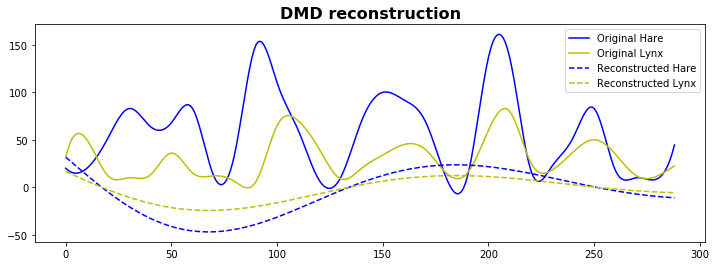

In [12]:
h=0
l=1

labels=["Hare", "Lynx"]

plt.figure(figsize=(12, 4))
plt.plot(X.T[:,h], "b", label=str("Original " + labels[h]))
plt.plot(X.T[:,l], "y", label=str("Original " + labels[l]))

plt.plot(Xdmd.T[:,h], "b--", label="Reconstructed " + labels[h])
plt.plot(Xdmd.T[:,l], "y--", label="Reconstructed " + labels[l])

plt.title("DMD reconstruction", fontsize=fontsize, weight=weight);
plt.legend()

### Note: with only 29 observations apiece (original DMD dataset), there are no imaginary components for Lambda.  Any interpolation improves this

578 (2, 578) (578,) (2, 578)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


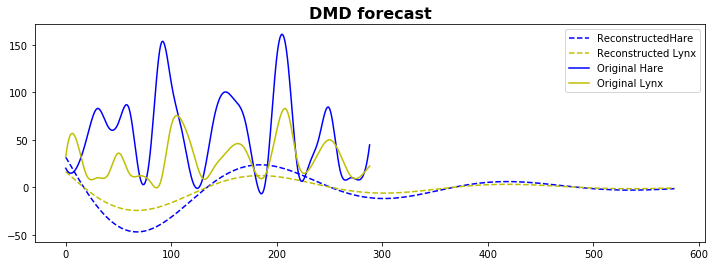

In [14]:
t_forecast = t*2
Xdmd = forecast(Phi, Omega, t_forecast, b, r, dt)

h=0
l=1

labels=["Hare", "Lynx"]

fig, axes = plt.subplots(figsize=(12, 4))
axes.plot(Xdmd.T[:,h], "b--", label="Reconstructed" + labels[h])
axes.plot(Xdmd.T[:,l], "y--", label="Reconstructed " + labels[l])
axes.plot(X.T[:,h], "b", label=str("Original " + labels[h]))
axes.plot(X.T[:,l], "y", label=str("Original " + labels[l]))
axes.legend()
    
plt.title("DMD forecast", fontsize=fontsize, weight=weight);

In [15]:
X.T.shape, Xdmd.T.shape

((289, 2), (578, 2))

#### Save the DMD model components, note densified points

DMD model reconstruction requires:  Phi, b, Omega, and r

In [16]:
DMD_components = [Phi, b, Omega, r]

DMD_fn = model_dir + str("DMD" + "_" + str(make_it_dense) + "pts.pkl")

if not os.path.exists(DMD_fn):
    with open(DMD_fn, "wb") as file:
        pickle.dump(DMD_components, file)   
else:
    print(DMD_fn, "exists")

/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_10pts.pkl exists


---

## Question 2.  Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

Hankel shape: (60, 60)
39


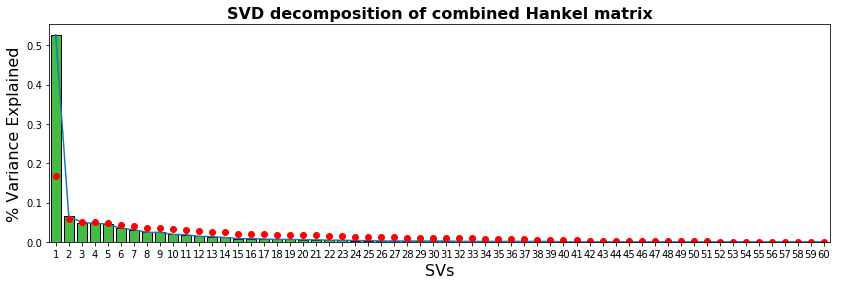

In [18]:
import seaborn as sns
from scipy.linalg import hankel

# Construct Hankel matrix
combined=df.values[:, 1:]
H_combined = hankel(combined)
print("Hankel shape:", H_combined.shape)

# Take SVD of H
u, s, v = np.linalg.svd(H_combined)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(1, figsize=(14, 4), sharey=True)
ax.plot(var_explained)
ax.plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax.set_xlabel('SVs', fontsize=16)
ax.set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax);
plt.title("SVD decomposition of combined Hankel matrix", fontsize=fontsize, weight=weight);

SVD on combined matrix shows 39 potential variables involved in the system

This suggests that there are quite a few latent variables not being measured in this dynamic system as we are only measuring 2 variables (lynx and hare)

#### Run DMD on combined Hankel matrix, interpolating to same degree as DMD models

In [69]:
# make_it_dense = None
make_it_dense = 10

if make_it_dense is not None:
    # With interpolation
    t = df.Year.values
    dt = (t[1] - t[0])/make_it_dense

    # Interpolate for more points
    years, dense_hare = densify(t, df.Hare.values, dt)
    years, dense_lynx = densify(t, df.Lynx.values, dt)

    X_dense = np.stack((dense_hare, dense_lynx)).T # in form time, states
    H_combined = hankel(X_dense)
    print(H_combined.shape)

else:
    # Without interpolation
    H_combined = hankel(df.values[:, 1:3])
    t = df.Year.values
    dt = (t[1] - t[0])
    
print(dt, H_combined.shape)

(580, 580)
0.2 (580, 580)


In [70]:
X=H_combined[1:, :]
Xprime=H_combined[:-1, :]

X.shape, Xprime.shape

((579, 580), (579, 580))

In [71]:
r=39

Phi, Omega, b, Lambda = DMD(X, Xprime, r, dt)

print(" Phi : Omega : b ", )
print(Phi.shape, Omega.shape, b.shape)

 Phi : Omega : b 
(579, 39) (39,) (39,)


#### DMD reconstruction using Hankel matrices

In [72]:
t = X.shape[1]
Xdmd = forecast(Phi, Omega, t, b, r, dt)

580 (39, 580) (580,) (579, 580)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [73]:
X.T.shape, Xdmd.T.shape

((580, 579), (580, 579))

#### Plot DMD reconstruction

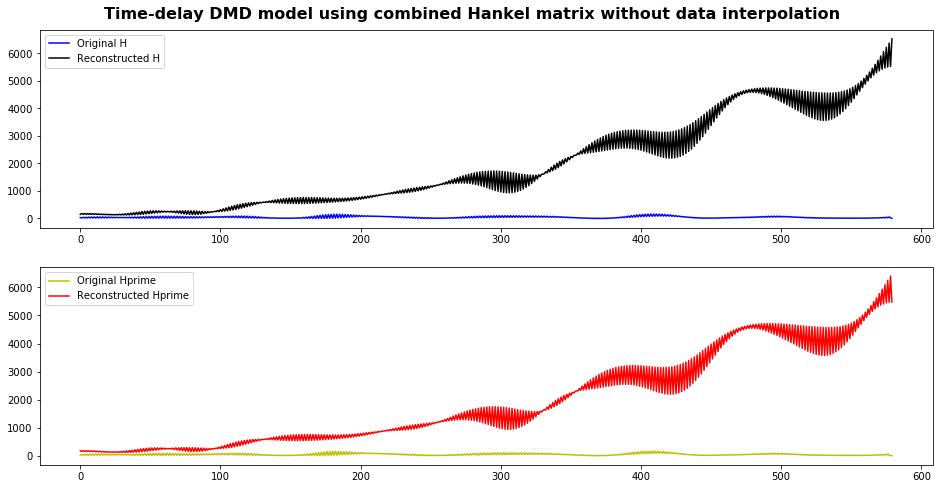

In [78]:
labels=["H", "Hprime"]
style_og=["b", "y"]
style_recon=["k-", "r-"]

fig, ax = plt.subplots(2, 1, figsize=(16,8))

for i in range(0, len(labels)):
    ax[i].plot(X.T[:, i], style_og[i], label=str("Original " + labels[i]))
    ax[i].plot(Xdmd.T[:, i], style_recon[i], label="Reconstructed " + labels[i])
    ax[i].legend()
    
plt.suptitle("Time-delay DMD model using combined Hankel matrix without data interpolation", 
             y=y_position, fontsize=fontsize, weight=weight);

In [ ]:
labels=["H", "Hprime"]
style_og=["b", "y"]
style_recon=["k-", "r-"]

fig, ax = plt.subplots(2, 1, figsize=(16,8))

for i in range(0, len(labels)):
    ax[i].plot(X.T[:, i], style_og[i], label=str("Original " + labels[i]))
    ax[i].plot(Xdmd.T[:, i], style_recon[i], label="Reconstructed " + labels[i])
    ax[i].legend()
    
plt.suptitle("Time-delay DMD model using combined Hankel matrix without data interpolation", 
             y=y_position, fontsize=fontsize, weight=weight);

### Forecast 

In [104]:
t_forecast = int(t*1.2)

Xdmd = forecast(Phi, Omega, t_forecast, b, r, dt)

696 (39, 696) (696,) (579, 696)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


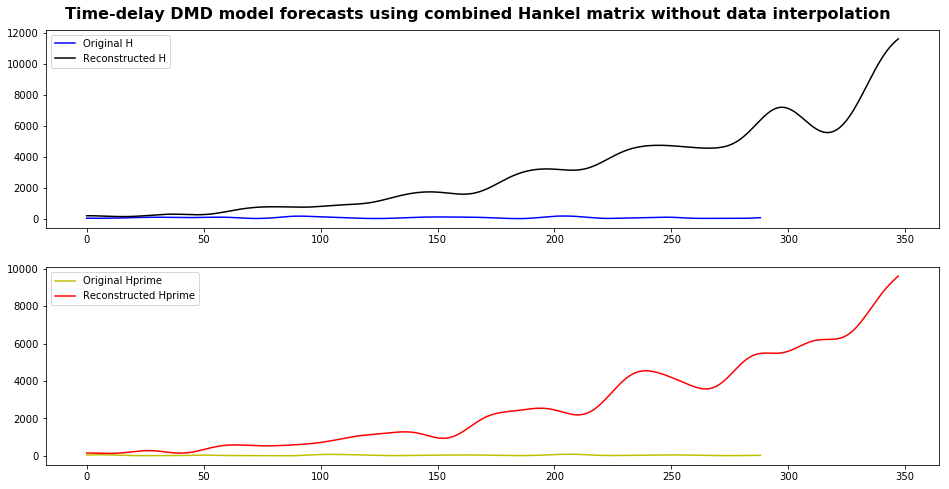

In [105]:
labels=["H", "Hprime"]
style_og=["b", "y"]
style_recon=["k-", "r-"]

fig, ax = plt.subplots(2, 1, figsize=(16,8))

for i in range(0, len(labels)):
    ax[i].plot(X.T[i][1::2], style_og[i], label=str("Original " + labels[i]))
    ax[i].plot(Xdmd.T[:,i][1::2], style_recon[i], label="Reconstructed " + labels[i])
    ax[i].legend()
    
plt.suptitle("Time-delay DMD model forecasts using combined Hankel matrix without data interpolation", 
             y=y_position, fontsize=fontsize, weight=weight);    

#### Save DMD with Hankel model with pickle

In [106]:
DMD_components = [Phi, b, Omega, r]

DMD_fn = model_dir + str("DMD_combinedHankel" + "_" + str(make_it_dense) + "pts.pkl")

if not os.path.exists(DMD_fn):
    with open(DMD_fn, "wb") as file:
        pickle.dump(DMD_components, file)   
else:
    print(DMD_fn, "exists")